In [1]:
#IMPORT NECESSARY PACKAGES
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.lib import grdevices
base = importr('base')
utils = importr('utils')
import os
import pickle
import numpy as np
import pandas as pd
import IPython
from IPython.display import Image, display
graphics = importr('graphics')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
import matplotlib.pyplot as plt
import pymysql.cursors
import datetime
import matplotlib.gridspec as grd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from time import mktime
if not ro.packages.isinstalled('openair'):
    utils.install_packages('openair')
r=ro.r
r.library('openair')

C:\Users\agmey\Anaconda3\envs\CO2_Eddy\lib\site-packages\rpy2\robjects\packages.py:347: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn("The symbol '%s' is not in this R namespace/package." % name)


'openair','tools','stats','graphics',...,'utils','datasets','methods','base'


In [2]:
#Ask the user for the date range between which data will be pulled from SQL
def get_date_range():
    date1=input("Enter Start Date YYYY-mm-DD: ")
    date2=input("Enter End Date YYYY-mm-DD: ")
    return date1,date2

In [3]:
def sql_connect():
    #Connect to SQL database with username and pw
    mydb = pymysql.connect(
        host='155.98.6.253',
        user='EddyFlux',
        passwd = 'UvTrhM_yFo71X2',
        database = 'CO2_Eddy'
        )
    
    #Set up cursor (allows navigation through SQL syntax)
    mycursor = mydb.cursor()
    
    return mycursor

In [4]:
def get_LI_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" LI_8100 Data         # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, Cdry\
                        FROM {}\
                        WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                        order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    LI_vent = pd.DataFrame(list(data)) #convert imported data to dataframe
    LI_vent.columns = ['Local_DT','EPOCH_TIME','CO2'] #name columns
    cols = LI_vent.columns.drop('Local_DT') #get all column names beside date column
    LI_vent[cols]=LI_vent[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return LI_vent

In [5]:
def get_multiplexer_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Multiplexer Data     # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    #Connect to SQL
    mycursor = sql_connect()   
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Multiplexer = pd.DataFrame(list(data)) #convert imported data into a dataframe
    Multiplexer.columns = ['Local_DT','EPOCH_TIME','CO2_1','CO2_2','CO2_3','Rotations','Wind_Velocity','Wind_Direction','Temp','Location'] #name columns
    cols = Multiplexer.columns.drop('Local_DT') #get all column names but date column
    Multiplexer[cols]=Multiplexer[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Multiplexer

In [6]:
def get_vent_anem_temp_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Vent_Anem_Temp = pd.DataFrame(list(data)) #convert imported data to a dataframe
    Vent_Anem_Temp.columns = ['Local_DT','EPOCH_TIME','Rotations','Velocity','Temp_1','Temp_2'] #name columns
    cols = Vent_Anem_Temp.columns.drop('Local_DT') #get all column names but date
    Vent_Anem_Temp[cols]=Vent_Anem_Temp[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Vent_Anem_Temp

In [7]:
def get_picarro_data(tablename,date1,date2):
    ###################################################################
    # Function to get exclusively "Spike Necessary" Picarro Data from #
    # SQL. Input the SQL Tablename, and date range between which data #
    # will be fetched. For one day's worth of data, enter the same    #
    # Date.                                                           #
    ###################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, CO2_dry, CH4_dry, ANEMOMETER_UY, ANEMOMETER_UX, ANEMOMETER_UZ\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    Picarro = pd.DataFrame(list(data)) #convert data to a dataframe
    Picarro.columns = ['Local_DT','EPOCH_TIME','CO2','CH4','ANEM_Y','ANEM_X','ANEM_Z'] #name columns
    cols = Picarro.columns.drop('Local_DT') #get all column names but date
    Picarro[cols]=Picarro[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return Picarro

In [8]:
#Script pulls in all of the necessary data in the date range input into the function
#Inputs: The names of each SQL table
#        date1 - start date for range of data to pull
#        date2 - end date for range of data to pull
def get_sql_data(LI_vent_sql_tablename,Multiplexer_sql_tablename,\
                 Vent_Anem_Temp_sql_tablename,Picarro_sql_tablename,date1,date2):
    
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################

    #Import source (LI_8100_Vent) data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        LI_vent = get_LI_data(LI_vent_sql_tablename,date1,date2)
    except ValueError:
        LI_vent = pd.DataFrame() #set empty dataframe
        pass
    
    
    #Import Multiplexer data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Multiplexer = get_multiplexer_data(Multiplexer_sql_tablename,date1,date2)
    except ValueError:
        Multiplexer = pd.DataFrame() #make empty dataframe
        pass
    
    #Import Vent_Anem_Temp data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Vent_Anem_Temp = get_vent_anem_temp_data(Vent_Anem_Temp_sql_tablename,date1,date2)
    except ValueError:
        Vent_Anem_Temp = pd.DataFrame() #make empty dataframe
        pass

    
    #Import Picarro data
    #If there is a value error (no data in table for date range), set up an empty dataframe and pass the error
    try:
        Picarro = get_picarro_data(Picarro_sql_tablename,date1,date2)
    except ValueError:
        Picarro = pd.DataFrame() #make empty dataframe
        pass
    
    return LI_vent, Multiplexer, Vent_Anem_Temp, Picarro #return all of the fetched dataframes

In [9]:
#Plot a simple graph with local_dt on the x axis, and an input (y_ax) on the y axis
def simple_plot(df,y_ax):
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df['Local_DT'],df[y_ax]) #plot
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()

In [24]:
#Make a figure of multiple plots plotted above one another. X axes have the same values
def plot_vertical_stack(**kwargs):
    num_plots = len(kwargs.items())
    fig = plt.figure(figsize = (num_plots*5,5))
    gs = grd.GridSpec(num_plots,1)
    i=0
    for key, value in kwargs.items():
        if i == 0:
            ax = fig.add_subplot(gs[i])
        else:
            ax = fig.add_subplot(gs[i],sharex=ax)
        if key == 'wd':
            ax.scatter(value['Local_DT'],value[key],s=.5)
        else: 
            ax.plot(value['Local_DT'],value[key])
        if ('ANEM_X' in value.columns) & (key == 'CO2'):
            ax.set_ylim([390,1000])
            
            
        i+=1
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show()    
        

In [14]:
#This function allows the user to specify the range over which to plot picarro data
def plot_refinement_picarro(df):
    #plot_vertical_stack(df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref: #continue asking user to refine until command is given
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plot_vertical_stack(CO2=df1,wd=df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
    
    return df1 #return the df with the user chosen range

In [15]:
#This function allows the user to specify the range over which to plot LI data
def plot_refinement_LI(df):
    fig = plt.figure()
    plt.plot(df['Local_DT'],df['CO2'])  #plot the data
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show()
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False    
        df1=df
    while cont_ref:       #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ")  #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ")   #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plt.plot(df1['Local_DT'],df1['CO2']) #plot over that range
        plt.gcf().autofmt_xdate()
        fig.tight_layout()
        plt.show()
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [16]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_multiplexer(df):
    plot_vertical_stack(df) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        plot_vertical_stack(df1) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [17]:
#This function allows the user to specify the range over which to plot Multiplexer data
def plot_refinement_vent_anem_temp(df):
    simple_plot(df,'Velocity') #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    if ask == 'y':
        cont_ref = False
        df1=df
        
    while cont_ref:          #continue asking user to refine until command is given 
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        df1 = df.loc[(df['Local_DT']>=DT1)&(df['Local_DT']<=DT2)] #clip the data to the range given

        simple_plot(df1,'Velocity') #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
            
    return df1 #return the df with the user chosen range

In [18]:
def fill_multiplexer_gaps(df):
    st = df['EPOCH_TIME'].min()
    end =  df['EPOCH_TIME'].max()

    x = df.set_index('EPOCH_TIME').reindex(range(st,end,1)).interpolate().rename_axis('EPOCH_TIME').reset_index()

    x['Local_DT'] = pd.to_datetime(x['EPOCH_TIME'],unit='s') - pd.Timedelta('06:00:00')

    return x

In [19]:
def wind_dir(x,y,pos):
    def add_360(angle):
        if angle < 0:
            result = angle+360
        else:
            result = angle
        return result
    if pos == 1:
        result = add_360(-90 - (np.arctan2(y,x)/np.pi*180))
    elif pos == 2:
        result = add_360(90 - (np.arctan2(y,x)/np.pi*180))
    return result

In [20]:
def wind_add(df,pos):
    df['wd'] = df.apply(lambda row: wind_dir(row['ANEM_X'],row['ANEM_Y'],pos),axis=1)
    df['ws'] = df.apply(lambda row : np.sqrt(row['ANEM_X']**2+row['ANEM_Y']**2),axis=1)
    return df

In [12]:
date1,date2 = get_date_range()
LI_vent, Multiplexer, Vent_Anem_Temp, Picarro, \
= get_sql_data("Aug2019_LI_8100_Vent",\
              "Aug2019_Multiplexer","Aug2019_Vent_Anem_Temp",\
              "Aug2019_Picarro",date1,date2)
#Multiplexer = get_multiplexer_data("Aug2019_Multiplexer_copy",date1,date2)


Enter Start Date YYYY-mm-DD:  2019-10-03
Enter End Date YYYY-mm-DD:  2019-10-03


In [22]:
Picarro = wind_add(Picarro,2)

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-10-03 10:00:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-10-03 16:00:00


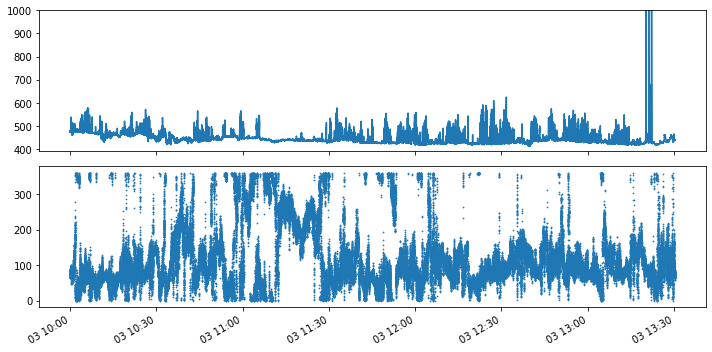

Is this an acceptable range?  y


In [25]:
clip = plot_refinement_picarro(Picarro)


In [ ]:
clip

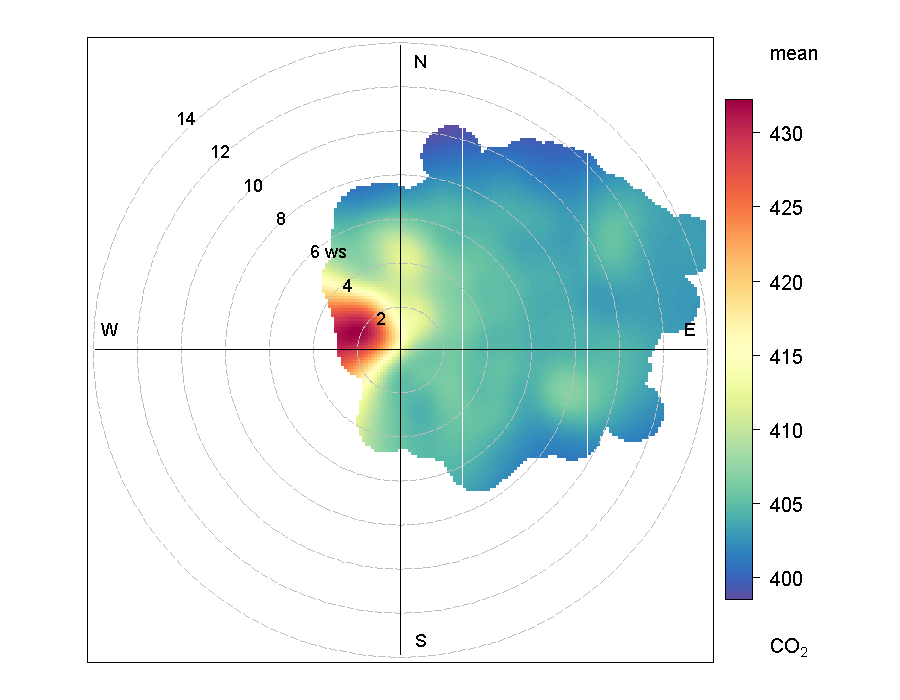

In [70]:
pandas2ri.activate()
r_dataframe = pandas2ri.py2ri(clip)

with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=900, height=700, res=150) as img:
    r.polarPlot(r_dataframe,'CO2')

IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))


In [ ]:
#x = [1,.866,.707,.5,0,-.5,-.707,-.866,-1,-.866,-.707,-.5,0,.5,.707,.866]
#y=[0,.5,.707,.866,1,.866,.707,.5,0,-.5,-.707,-.866,-1,-.866,-.707,-.5]
x = [1]
y = [-3]
df=pd.DataFrame({'ANEM_X':x,'ANEM_Y':y})
df = wind_add(df)
df